## Project Description

### Overview

This project involves collecting and analyzing data related to adoptable dogs from Petfinder.com, a reputable online database of animals who need homes. The data was collected on October 24th, 2024 using web scraping techniques to gather information on dogs available for adoption in a specific region.

### Source of the Data

- Website: Petfinder.com
- Focus: Adoptable dogs listed on the website
- Location Filter: Data was restricted to dogs available in Atlanta, GA, to maintain a manageable dataset and focus on a specific geographical area

### Data Collected

The following information was collected for each dog:
- Pet ID: A unique identifier assigned by Petfinder
- Name: The name given to the dog by the shelter or rescue organization
- Primary Breed: The primary breed of the dog
- Secondary Breed: The secondary breed of the dog
- Mixed Breed: An indicator (e.g, Yes or No) showing whether the dog is of mixed breed
- Age: Categorized as Baby, Young, Adult, or Senior
- Sex: Male or Female
- Size: The size category of the dog, such as Small, Medium, Large, or Extra Large
- Primary Colour: The predominant color of the dog's coat
- Secondary Colour: The secondary color present in the dog's coat, if any
- Coat Length: The length of the dog's coat, categorized as Hairless, Short, Medium, or Long
- Shelter Name: The name of the shelter or rescue organization currently caring for the dog
- Zip Code: The postal code of the shelter's location
- Number of Photos: The number of photos available for the dog in its listing
- Children: An indicator of whether the dog is suitable for homes with children
- Cats: An indicator of whether the dog gets along well with cats
- Other Dogs: An indicator of whether the dog is friendly towards other dogs
- Characteristics: Descriptive traits and personality attributes of the dog
- House Trained: An indicator of whether the dog is trained to eliminate outside or in designated areas
- Health: Information regarding the dog's health status, including vaccinations, spay/neuter status, and any special needs
- Adoption Fee: The cost associated with adopting the dog, when available

To begin, I am collecting all available data for each dog and will refine the scope during the analysis phase once I determine the specific questions I want to address.

### Decisions to Restrict Data Collection

- Scope Limitation: For proof of concept purposes, data was only collected for adoptable dogs in Atlanta, GA and only three pages worth of data were pulled (119 observations)
- Respecting Terms of Service: Ensured that the scraping process complied with Petfinder's terms of use and robots.txt file
- Error Handling: Implemented exception handling to manage unexpected issues without causing undue strain on the website
- Duplicate Avoidance: Implemented checks to prevent collecting duplicate entries, ensuring each pet is uniquely represented
- Data Validation: Included steps to validate and clean data, such as handling missing values and standardizing formats

## Importing Needed Libraries 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import json
import re
import matplotlib.pyplot as plt
import numpy as np

## Pulling the Data

In [20]:
# Function to navigate to the desired page 
def search_dogs(URL, location, driver):
    try:
        # Navigating to the website
        driver.get(URL)

        # Giving the website some time to load (to ensure "Dogs" will set in the animal type search bar) 
        time.sleep(2)

        # Waiting for animal type search bar to load and be ready for interaction 
        form_type = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, 'simpleSearchAnimalType'))
        )
        form_type.clear()
        form_type.send_keys("Dogs")

        # Finding the location search bar element and ensure it is ready for interaction 
        form_location = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, 'simpleSearchLocation'))
        )
        form_location.clear()
        form_location.send_keys(location)
        
        # Allowing the location to be set before clicking the search button
        time.sleep(2)

        # Clicking the search button to submit the form
        search_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, 'petSearchBarSearchButton'))
        )
        # search_button = driver.find_element(By.ID, 'petSearchBarSearchButton')
        search_button.click()

    except Exception as e:
        # Handling any errors that occur during the search process
        print(f"An error occurred while searching for adoptable dogs: {str(e)}")

In [73]:
def get_info(driver):
    import traceback
    try:
        max_pages = 3
        page_counter = 1  

        dog_data_list = []
        # Creating a set to keep track of pet IDs 
        processed_pet_ids = set()  

        while page_counter <= max_pages:
            print(f"Processing page {page_counter}...")

            # Waiting for the dog cards to be clickable
            WebDriverWait(driver, 40).until(
                EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
            )
            dog_cards = driver.find_elements(By.XPATH, '//a[@class="petCard-link"]')
            print(f"Found {len(dog_cards)} dog cards on page {page_counter}.")

            # Extracting the hrefs from the dog cards
            dog_links = [card.get_attribute('href') for card in dog_cards]

            # Looping through each dog card on the page
            for i, link in enumerate(dog_links):
                try:
                    print(f"Processing dog {i + 1} on page {page_counter}.")

                    # Navigating to the dog detail page
                    driver.get(link)

                    # Waiting for the dog's detail page to load
                    WebDriverWait(driver, 40).until(
                        EC.presence_of_element_located((By.XPATH, '//pf-ad[contains(@id, "PetDetail")]'))
                    )

                    # Finding the <pf-ad> element that contains the dogs details 
                    pf_ad = driver.find_element(By.XPATH, '//pf-ad[contains(@id, "PetDetail")]')
                    targeting_data = pf_ad.get_attribute("targeting")
                    dog_info = json.loads(targeting_data)

                    # Getting the pet ID
                    pet_id = dog_info.get('Pet_ID', 'N/A')
                    if pet_id == 'N/A':
                        print(f"Pet ID not found for dog {i + 1} on page {page_counter}. Skipping.")
                        continue

                    # Checking if pet ID is already processed
                    if pet_id in processed_pet_ids:
                        print(f"Pet ID {pet_id} already processed. Skipping dog {i + 1} on page {page_counter}.")
                        continue

                   # Extracting desired field names from dog_info 
                    pet_id = dog_info.get('Pet_ID', 'N/A')
                    pet_name = dog_info.get('Pet_Name', 'N/A')
                    primary_breed = dog_info.get('Primary_Breed', 'N/A')
                    secondary_breed = dog_info.get('Secondary_Breed', 'N/A')
                    mixed_breed = dog_info.get('Mixed_Breed', 'N/A')
                    age = dog_info.get('Age', 'N/A')
                    gender = dog_info.get('Gender', 'N/A')
                    size = dog_info.get('Size', 'N/A')
                    primary_colour = dog_info.get('Primary_color', 'N/A')
                    secondary_colour = dog_info.get('Secondary_color', 'N/A')
                    coat_length = dog_info.get('Coat_length', 'N/A')
                    shelter_name = dog_info.get('Shelter_Name', 'N/A')
                    shelter_id = dog_info.get('Shelter_ID', 'N/A')
                    zip_code = dog_info.get('Zip_Code', 'N/A')
                    num_photos = dog_info.get('Number_of_photos_in_profile', 'N/A')
                    children = dog_info.get('Good_with_children', 'N/A')
                    cats = dog_info.get('Good_with_cats', 'N/A')
                    other_dogs = dog_info.get('Good_with_dogs', 'N/A')
                    other_animals = dog_info.get('Good_with_other_animals', 'N/A')
                    fee_waived = dog_info.get('Adoption_fee_waived', 'N/A')

                    # Extracting desired field names not in dog_info 
                    WebDriverWait(driver, 40).until(
                        EC.presence_of_element_located((By.XPATH, '//span[@data-test="Pet_Location"]'))
                    )
                    try:
                        pet_location = driver.find_element('xpath', '//span[@data-test="Pet_Location"]').text
                    except:
                        pet_location = 'N/A'

                    try:
                        characteristics = driver.find_element('xpath', '//dt[contains(text(), "Characteristics")]/following-sibling::dd').text
                    except:
                        characteristics = 'N/A'

                    try:
                        house_trained = driver.find_element('xpath', '//dt[contains(text(), "House-trained")]/following-sibling::dd').text
                    except:
                        house_trained = 'N/A'

                    try:
                        health = driver.find_element('xpath', '//dt[contains(text(), "Health")]/following-sibling::dd').text
                    except:
                        health = 'N/A'

                    try:
                        # First checking to see if adoption fee is in the about section
                        adoption_fee = driver.find_element('xpath', '//dt[contains(text(), "Adoption fee")]/following-sibling::dd').text
                    except:
                        # If not in the about section, checking to see if its mentioned in the pet story 
                        # First ensure the pet story element can be located 
                        WebDriverWait(driver, 40).until(
                        EC.presence_of_element_located((By.XPATH, '//div[@data-test="Pet_Story_Section"]'))
                            )
                        try:
                            pet_story_section = driver.find_element('xpath', '//div[@data-test="Pet_Story_Section"]').text
                            # Using regex to check for adoption fee in the pet story
                            adoption_fee_search = re.search(r'Adoption fee (\d+)', pet_story_section, re.IGNORECASE)

                            if adoption_fee_search:
                                adoption_fee = adoption_fee_search.group(1)
                            else:
                                adoption_fee = 'N/A'  
                        except:
                            # If neither method works, set the adoption fee to 'N/A'
                            adoption_fee = 'N/A'

                            
                    # Appending a dictionary of all the values for the given dog to the dog_data_list 
                    dog_data_list.append({
                        'pet_id': pet_id,
                        'pet_name': pet_name,
                        'primary_breed': primary_breed,
                        'secondary_breed': secondary_breed,
                        'mixed_breed': mixed_breed,
                        'age': age,
                        'gender': gender,
                        'size': size,
                        'primary_colour': primary_colour,
                        'secondary_colour': secondary_colour,
                        'coat_length': coat_length,
                        'shelter_name': shelter_name,
                        'shelter_id': shelter_id,
                        'zip_code': zip_code,
                        'num_photos': num_photos,
                        'children': children,
                        'cats': cats,
                        'other_dogs': other_dogs,
                        'other_animals': other_animals,
                        'fee_waived': fee_waived,
                        'pet_location': pet_location,
                        'characteristics': characteristics,
                        'house_trained': house_trained,
                        'health': health,
                        'adoption_fee': adoption_fee
                    })
                    print(f"Collected data for pet_name {pet_name} with pet_id {pet_id}")

                    # Adding the pet ID to the set of processed IDs
                    processed_pet_ids.add(pet_id)

                    # Navigating back to the results page
                    driver.back()

                    # Waiting for dog cards to reload
                    WebDriverWait(driver, 40).until(
                        EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
                    )

                # Error message if cannot process dog on the given page but continuing with the next dog 
                except Exception as e:
                    print(f"Error processing dog {i + 1} on page {page_counter}: {e}")
                    traceback.print_exc()
                    continue

            # Moving to the next page
            if page_counter < max_pages:
                try:
                    # Wait for the pet cards to load
                    WebDriverWait(driver, 40).until(
                        EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
                    )
                    WebDriverWait(driver, 30).until(
                            EC.element_to_be_clickable((By.XPATH, '//button[span[@class="fieldBtn-label" and text()="Next"]]'))
                        )
                    
                    # Checking if "Next" button exists
                    next_buttons = driver.find_elements(By.XPATH, '//button[span[@class="fieldBtn-label" and text()="Next"]]')
                    if next_buttons:
                        next_button = next_buttons[0]
                        # Scrolling to the "Next" button
                        driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
                        # Waiting for the button to be clickable
                        WebDriverWait(driver, 30).until(
                            EC.element_to_be_clickable((By.XPATH, '//button[span[@class="fieldBtn-label" and text()="Next"]]'))
                        )
                        next_button.click()
                        print(f"Current URL after clicking 'Next': {driver.current_url}")
                        current_url = driver.current_url
                        WebDriverWait(driver, 30).until(EC.url_changes(current_url))

                        # Waiting for new dog cards to load
                        WebDriverWait(driver, 40).until(
                            EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
                        )
                    else:
                        print("No more pages to navigate.")
                        break

                # Error message if cannot move to the next page and stopping the loop
                except Exception as e:
                    print(f"Error moving to the next page: {e}")
                    traceback.print_exc()
                    driver.save_screenshot(f'error_moving_to_next_page_{page_counter}.png')
                    break

                # Incrementing the page counter after successfully moving to the next page
                page_counter += 1
            else:
                break
        
        # Returning the lists of dictionaries (each dictionary representing a dog)
        return dog_data_list

    finally:
        # Closing the browser once done
        driver.quit()


In [74]:
chrome_options = Options()
chrome_options.add_argument("headless")

# Setting the driver parameter
driver = webdriver.Chrome(options=chrome_options)
# driver = webdriver.Chrome()
# Setting the URL parameter
URL = "https://www.petfinder.com"
# Setting the location parameter 
location = "Atlanta, GA"
# Calling the search dog function with the above arguments for the parameters
search_dogs(URL, location, driver)

# Giving the dog page 5 seconds to load before clicking in to each card and extracting the information 
time.sleep(5)

# Calling the get_info4 function and saving the returned output to dog_data_list2
dog_data_list = get_info(driver)

Processing page 1...
Found 40 dog cards on page 1.
Processing dog 1 on page 1.
Collected data for pet_name Jackson with pet_id 72096072
Processing dog 2 on page 1.
Collected data for pet_name Candy with pet_id 73681457
Processing dog 3 on page 1.
Collected data for pet_name Marshmallow with pet_id 73681390
Processing dog 4 on page 1.
Collected data for pet_name Bowie with pet_id 73491201
Processing dog 5 on page 1.
Collected data for pet_name Ezra - Pending with pet_id 70952437
Processing dog 6 on page 1.
Collected data for pet_name Athena with pet_id 73327856
Processing dog 7 on page 1.
Collected data for pet_name Sven with pet_id 73327823
Processing dog 8 on page 1.
Collected data for pet_name Storm with pet_id 72600711
Processing dog 9 on page 1.
Collected data for pet_name Dio with pet_id 72455199
Processing dog 10 on page 1.
Collected data for pet_name Freddy with pet_id 59347792
Processing dog 11 on page 1.
Collected data for pet_name Boulder with pet_id 73671020
Processing dog 1

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Patsy FOSTER NEEDED TOO!!! with pet_id 72813759
Error processing dog 3 on page 3: Message: 

Processing dog 4 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Dodger with pet_id 72765055
Error processing dog 4 on page 3: Message: 

Processing dog 5 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Lady with pet_id 72715658
Error processing dog 5 on page 3: Message: 

Processing dog 6 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Rosie with pet_id 72715657
Error processing dog 6 on page 3: Message: 

Processing dog 7 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Keanu with pet_id 72706844
Error processing dog 7 on page 3: Message: 

Processing dog 8 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Prince with pet_id 72706846
Error processing dog 8 on page 3: Message: 

Processing dog 9 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Sadie with pet_id 72630047
Error processing dog 9 on page 3: Message: 

Processing dog 10 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Orrelo with pet_id 72630048
Error processing dog 10 on page 3: Message: 

Processing dog 11 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Sam with pet_id 72535268
Error processing dog 11 on page 3: Message: 

Processing dog 12 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Rizzo with pet_id 72535267
Error processing dog 12 on page 3: Message: 

Processing dog 13 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Seabiscuit with pet_id 72535266
Error processing dog 13 on page 3: Message: 

Processing dog 14 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Doreen with pet_id 72314770
Error processing dog 14 on page 3: Message: 

Processing dog 15 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Piccolo with pet_id 72270468
Error processing dog 15 on page 3: Message: 

Processing dog 16 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Athena with pet_id 72113102
Error processing dog 16 on page 3: Message: 

Processing dog 17 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Tyson with pet_id 71809761
Error processing dog 17 on page 3: Message: 

Processing dog 18 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Jett with pet_id 71786745
Error processing dog 18 on page 3: Message: 

Processing dog 19 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Betsy with pet_id 71786746
Error processing dog 19 on page 3: Message: 

Processing dog 20 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Jojo with pet_id 71757938
Error processing dog 20 on page 3: Message: 

Processing dog 21 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Romello with pet_id 71708839
Error processing dog 21 on page 3: Message: 

Processing dog 22 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Dobbins with pet_id 71692320
Error processing dog 22 on page 3: Message: 

Processing dog 23 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Chico aka Chichi with pet_id 71641218
Error processing dog 23 on page 3: Message: 

Processing dog 24 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Boomer with pet_id 71573717
Error processing dog 24 on page 3: Message: 

Processing dog 25 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Dexter with pet_id 71310202
Error processing dog 25 on page 3: Message: 

Processing dog 26 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Teddy *FOSTER NEEDED TOO! with pet_id 71287062
Error processing dog 26 on page 3: Message: 

Processing dog 27 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Cullen with pet_id 71248825
Error processing dog 27 on page 3: Message: 

Processing dog 28 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Sugarfoot with pet_id 71160321
Error processing dog 28 on page 3: Message: 

Processing dog 29 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Piper with pet_id 70936634
Error processing dog 29 on page 3: Message: 

Processing dog 30 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Bingo *FOSTER TO ADOPT? with pet_id 70698610
Error processing dog 30 on page 3: Message: 

Processing dog 31 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Abraham with pet_id 70616598
Error processing dog 31 on page 3: Message: 

Processing dog 32 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Avali with pet_id 70507922
Error processing dog 32 on page 3: Message: 

Processing dog 33 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Jerry FOSTER NEEDED TOO! with pet_id 70275551
Error processing dog 33 on page 3: Message: 

Processing dog 34 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Marie Urgently needs foster or adopter with pet_id 70149218
Error processing dog 34 on page 3: Message: 

Processing dog 35 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Nalla with pet_id 70138557
Error processing dog 35 on page 3: Message: 

Processing dog 36 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Kiya with pet_id 70115419
Error processing dog 36 on page 3: Message: 

Processing dog 37 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Starla. Looking for Foster or Adopter with pet_id 69947262
Error processing dog 37 on page 3: Message: 

Processing dog 38 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Roxie with pet_id 69703926
Error processing dog 38 on page 3: Message: 

Processing dog 39 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Ollie with pet_id 69703927
Error processing dog 39 on page 3: Message: 

Processing dog 40 on page 3.


Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Jaxon with pet_id 69534379
Error processing dog 40 on page 3: Message: 



Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_66620/2234647443.py", line 159, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



In [121]:
# Saving data to dataframe
df_dog_info = pd.DataFrame(dog_data_list)

## Data Investigation and Cleaning 

In [97]:
display(df_dog_info)

,pet_id,pet_name,primary_breed,secondary_breed,mixed_breed,age,gender,size,primary_colour,secondary_colour,...,children,cats,other_dogs,other_animals,fee_waived,pet_location,characteristics,house_trained,health,adoption_fee
0,72096072,Jackson,Boxer,American Bulldog,True,Senior,Male,Medium,Brindle,,...,,False,False,,False,"Atlanta , GA","Friendly, Affectionate, Smart, Athletic, Food ...",Yes,"Vaccinations up to date, spayed / neutered.",N/A
1,73681457,Candy,Chiweenie,Mixed Breed,True,Baby,Female,Small,,,...,True,True,True,,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,450
2,73681390,Marshmallow,Great Pyrenees,,True,Baby,Female,Large,,,...,True,True,True,,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,500
3,73491201,Bowie,Labrador Retriever,Mixed Breed,True,Baby,Male,Large,,,...,True,,True,,False,"Atlanta , GA",N/A,Yes,Vaccinations up to date.,450
4,70952437,Ezra - Pending,Italian Greyhound,American Bulldog,True,Adult,Male,Medium,,,...,,True,False,,False,"Atlanta, GA",N/A,Yes,"Vaccinations up to date, spayed / neutered.",N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,70115419,Kiya,Rottweiler,,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,N/A
115,69947262,Starla. Looking for Foster or Adopter,Border Collie,Australian Cattle Dog / Blue Heeler,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,N/A
116,69703926,Roxie,Terrier,,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,N/A,N/A
117,69703927,Ollie,Terrier,,True,Young,Male,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,N/A,N/A


In [98]:
# Viewing data types
df_dog_info.dtypes

pet_id              object
pet_name            object
primary_breed       object
secondary_breed     object
mixed_breed           bool
age                 object
gender              object
size                object
primary_colour      object
secondary_colour    object
coat_length         object
shelter_name        object
shelter_id          object
zip_code            object
num_photos           int64
children            object
cats                object
other_dogs          object
other_animals       object
fee_waived            bool
pet_location        object
characteristics     object
house_trained       object
health              object
adoption_fee        object
dtype: object

In [99]:
# Counting number of observations
print("There are ", df_dog_info.shape[0], " observations in the dataset.")

There are  119  observations in the dataset.


### Missing Values

In [122]:
# Replacing blanks with nan to identify missing values 
df_dog_info = df_dog_info.replace(r'^\s*$', np.nan, regex=True)

col_names = df_dog_info.columns.tolist()
dogs_missing_count = df_dog_info[col_names].isna().sum()
dogs_missing_share = ((df_dog_info[col_names].isna().sum()/df_dog_info.shape[0])*100).round(0).astype(int)
dogs_missing_table = pd.DataFrame({
    'Missing Count': dogs_missing_count,
    'Missing Share (%)': dogs_missing_share
})

dogs_missing_table.reset_index(inplace=True)
dogs_missing_table.rename(columns={'index': 'Variable'}, inplace=True)

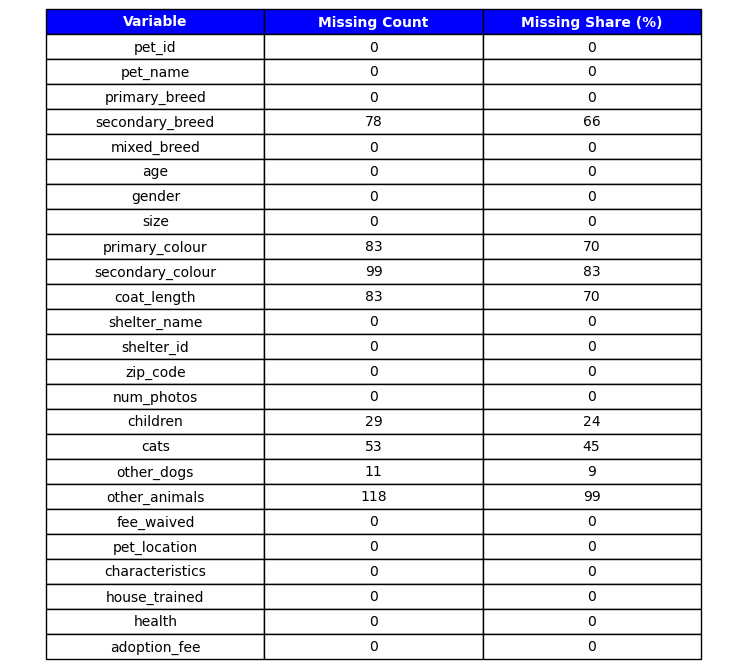

In [123]:

# Creating a formatted table 
fig, list_subfig = plt.subplots(figsize = (8,4))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)


table = list_subfig.table(cellText=dogs_missing_table.values, 
                  colLabels=dogs_missing_table.columns, 
                  loc='center', cellLoc='center')

table.scale(0.9, 1.5)  
list_subfig.axis('off')

# Formating the table
table.auto_set_font_size(False)
table.set_fontsize(10) 

for (i, j), cell in table.get_celld().items():
    if i == 0:  
        cell.set_facecolor('blue')  
        cell.set_text_props(color='white', weight='bold', fontsize=10)  
    else:  
        pass
    cell.set_edgecolor('black')  

plt.show()

In [101]:
# Creating a copy
df_dog_info_copy = df_dog_info.copy()

In [102]:
# Replacing null values with appropriate text 
df_dog_info_copy['secondary_breed'] = df_dog_info_copy['secondary_breed'].fillna('None')
df_dog_info_copy['primary_colour'] = df_dog_info_copy['primary_colour'].fillna('Unknown')
df_dog_info_copy['secondary_colour'] = df_dog_info_copy['secondary_colour'].fillna('None')
df_dog_info_copy['coat_length'] = df_dog_info_copy['coat_length'].fillna('Unknown')
df_dog_info_copy['children'] = df_dog_info_copy['children'].fillna('Unknown')
df_dog_info_copy['cats'] = df_dog_info_copy['cats'].fillna('Unknown')
df_dog_info_copy['other_dogs'] = df_dog_info_copy['other_dogs'].fillna('Unknown')

# Dropping other animals column since most values are missing 
df_dog_clean = df_dog_info_copy.drop(columns = ['other_animals'])

### Value Consistency 

#### Pet Name

In [104]:
# Looking at structure of some of the pet names 
print(df_dog_clean['pet_name'].unique())

['Jackson' 'Candy' 'Marshmallow' 'Bowie' 'Ezra - Pending' 'Athena' 'Sven'
 'Storm' 'Dio' 'Freddy' 'Boulder' 'Runni Man' 'Magpie' 'Ariel' 'Blanco'
 'Abby' 'Petey*' 'Wiler' 'Emma May' 'Aunt Bea' 'Eleanor' 'Moochie*'
 'Faith' 'Tuck' 'Bella (Sweet, smaller girl looking for solo pup home)'
 "Nelly (Beautiful sweet & shy girl needs the love she's never known)"
 'Shadow (Sweet neglected boy looking for his hero!)'
 "Rupert (Mama Cookie's Litter)" 'Jewel' 'Cosmo the Charismatic'
 'Mumford - "What they don\'t tell you about pittbulls is that they have to have lots of snuggles!"'
 'Queen Bean, the devoted Death Row kill shelter dog SPARKLING with lavish love for people!'
 'Legend' 'Eugene' 'Luna' 'G.G.' 'Monty' 'D.C.' 'Bama' 'Reese' 'Poppy'
 'Mitzi' 'Jake' 'Otto' 'Timmy' 'Bijou' 'Sundae' 'Curry' 'Zuko' 'Zara'
 'Bitsy' 'Betsy' 'Karen' 'Camacho' 'Ruscio' 'Kya' 'Scott' 'Athena Pup'
 'Apollo' 'Bogey' 'Misha Foster or Adopter Urgently Needed' 'Osada'
 'Josie' 'Jolene' 'Pepe' 'Muskrat' 'Rocky' 'Mishka

In [105]:
# Function to clean names 
def clean_dog_name(name):

    # Matching valid names using RegEX
    cleaned_name = re.match(r'^[A-Za-z][A-Za-z\.]*', name.strip())
    
    # If a match is found then return the cleaned name, otherwise return the original string 
    if cleaned_name:
        return cleaned_name.group(0)
    else:
        return name.strip()

# Applying the cleaning function to the pet_name column
df_dog_clean['clean_pet_names'] = df_dog_clean['pet_name'].apply(clean_dog_name)

# Checking the results 
print(df_dog_clean['clean_pet_names'].unique())

['Jackson' 'Candy' 'Marshmallow' 'Bowie' 'Ezra' 'Athena' 'Sven' 'Storm'
 'Dio' 'Freddy' 'Boulder' 'Runni' 'Magpie' 'Ariel' 'Blanco' 'Abby' 'Petey'
 'Wiler' 'Emma' 'Aunt' 'Eleanor' 'Moochie' 'Faith' 'Tuck' 'Bella' 'Nelly'
 'Shadow' 'Rupert' 'Jewel' 'Cosmo' 'Mumford' 'Queen' 'Legend' 'Eugene'
 'Luna' 'G.G.' 'Monty' 'D.C.' 'Bama' 'Reese' 'Poppy' 'Mitzi' 'Jake' 'Otto'
 'Timmy' 'Bijou' 'Sundae' 'Curry' 'Zuko' 'Zara' 'Bitsy' 'Betsy' 'Karen'
 'Camacho' 'Ruscio' 'Kya' 'Scott' 'Apollo' 'Bogey' 'Misha' 'Osada' 'Josie'
 'Jolene' 'Pepe' 'Muskrat' 'Rocky' 'Mishka' 'Max' 'Layton' 'Iggy' 'Ivy'
 'Luca' 'Leroy' 'Volt' 'Laddie' 'Cookie' 'Odin' 'Harley' 'Patsy' 'Dodger'
 'Lady' 'Rosie' 'Keanu' 'Prince' 'Sadie' 'Orrelo' 'Sam' 'Rizzo'
 'Seabiscuit' 'Doreen' 'Piccolo' 'Tyson' 'Jett' 'Jojo' 'Romello' 'Dobbins'
 'Chico' 'Boomer' 'Dexter' 'Teddy' 'Cullen' 'Sugarfoot' 'Piper' 'Bingo'
 'Abraham' 'Avali' 'Jerry' 'Marie' 'Nalla' 'Kiya' 'Starla.' 'Roxie'
 'Ollie' 'Jaxon']


In [110]:
# Dropping original pet name column 
df_dog_clean = df_dog_clean.drop(columns = ['pet_name'])

#### Adoption Fee

In [106]:
# Looking at unique adoption fees to identify different structures 
print(df_dog_clean['adoption_fee'].unique())

['N/A' '450' '500' '$600.00' '$250.00' '$300.00' '$200.00' '$325.00'
 '$475.00' '$400.00' '$350.00' '$450.00' '$500.00' '$375.00']


In [107]:
# Using regular expression to make consistent structure
df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].replace({r'\$': ''}, regex=True)
# df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].replace('N/A', np.nan)

# Converting to numeric coerce errors to NaN
df_dog_clean['adoption_fee'] = pd.to_numeric(df_dog_clean['adoption_fee'], errors='coerce')

# Converting to nullable integer type
df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].astype('Int64')

# Verifying results 
print(df_dog_clean['adoption_fee'].unique())

<IntegerArray>
[<NA>, 450, 500, 600, 250, 300, 200, 325, 475, 400, 350, 375]
Length: 12, dtype: Int64


In [108]:
# Viewing datatypes
df_dog_clean.dtypes

pet_id              object
pet_name            object
primary_breed       object
secondary_breed     object
mixed_breed           bool
age                 object
gender              object
size                object
primary_colour      object
secondary_colour    object
coat_length         object
shelter_name        object
shelter_id          object
zip_code            object
num_photos           int64
children            object
cats                object
other_dogs          object
fee_waived            bool
pet_location        object
characteristics     object
house_trained       object
health              object
adoption_fee         Int64
clean_pet_names     object
dtype: object

In [109]:
display(df_dog_clean)

,pet_id,pet_name,primary_breed,secondary_breed,mixed_breed,age,gender,size,primary_colour,secondary_colour,...,children,cats,other_dogs,fee_waived,pet_location,characteristics,house_trained,health,adoption_fee,clean_pet_names
0,72096072,Jackson,Boxer,American Bulldog,True,Senior,Male,Medium,Brindle,None,...,Unknown,False,False,False,"Atlanta , GA","Friendly, Affectionate, Smart, Athletic, Food ...",Yes,"Vaccinations up to date, spayed / neutered.",<NA>,Jackson
1,73681457,Candy,Chiweenie,Mixed Breed,True,Baby,Female,Small,Unknown,None,...,True,True,True,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,450,Candy
2,73681390,Marshmallow,Great Pyrenees,None,True,Baby,Female,Large,Unknown,None,...,True,True,True,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,500,Marshmallow
3,73491201,Bowie,Labrador Retriever,Mixed Breed,True,Baby,Male,Large,Unknown,None,...,True,Unknown,True,False,"Atlanta , GA",N/A,Yes,Vaccinations up to date.,450,Bowie
4,70952437,Ezra - Pending,Italian Greyhound,American Bulldog,True,Adult,Male,Medium,Unknown,None,...,Unknown,True,False,False,"Atlanta, GA",N/A,Yes,"Vaccinations up to date, spayed / neutered.",<NA>,Ezra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,70115419,Kiya,Rottweiler,None,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,<NA>,Kiya
115,69947262,Starla. Looking for Foster or Adopter,Border Collie,Australian Cattle Dog / Blue Heeler,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,<NA>,Starla.
116,69703926,Roxie,Terrier,None,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,N/A,<NA>,Roxie
117,69703927,Ollie,Terrier,None,True,Young,Male,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,N/A,<NA>,Ollie


### Numeric Summary

In [111]:
df_dog_clean.describe()

,num_photos,adoption_fee
count,119.000000,38.0
mean,3.731092,343.421053
std,1.394283,107.754132
min,0.000000,200.0
25%,3.000000,250.0
50%,3.000000,325.0
75%,4.500000,437.5
max,12.000000,600.0


There are only two numerical fields in the data at the moment, the number of photos that the dog has on their detail page, and the adoption fee (sometimes not provided).
- The mean number of a photos a dog has on their page is 3.7, with some variation, a few listings having no photos and some having up to 12
- The mean adoption fee of a dog is $343, with a wide spread in adoption fees, from $200 to $600

In [124]:
# Converting to csv
df_dog_clean.to_csv('dog_data_clean.csv')